# Single Qubit Time Dependent Hamiltonian Simulation 
Adapted from Townsend, "A Modern Approach to Quantum Mechanics," Section 4.4 (Magnetic Resonance)

In this notebook, we simulate the time dependent hamiltonian for the single qubit in Section 4.4 of Townsend. We then compate the result with the exact solution. 

The Hamiltonina is given as (Townsend Eq. 4.34):
$$
\hat{H}=-\hat{\mu} \cdot \mathbf{B}=-\frac{g q}{2 m c} \hat{\mathbf{S}} \cdot \mathbf{B}=-\frac{g q}{2 m c} \hat{\mathbf{S}} \cdot\left(B_{1} \cos \omega t \mathbf{i}+B_{0} \mathbf{k}\right)
$$

For simplicity, let:
$$
e g B_{1} / 2 m c=\omega_{1}
$$
$$
e g B_{0} / 2 m c=\omega_{0}
$$
$$
q=-e
$$

Therefore:

$$
\hat{H}=\frac{\omega_{0}}{2} \hat{\sigma}_{z}+\frac{\omega_{1}(\cos \omega t)}{2} \hat{\sigma}_{x}
$$

The Rabi's formula (Townsend(Eq. 4.45):
$$
|\langle-\mathbf{z} \mid \psi(t)\rangle|^{2}=\frac{\omega_{1}^{2} / 4}{\left(\omega_{0}-\omega\right)^{2}+\omega_{1}^{2} / 4} \sin ^{2} \frac{\sqrt{\left(\omega_{0}-\omega\right)^{2}+\omega_{1}^{2} / 4}}{2} t
$$

gives the exact probability of being in the lower energy spin-down state at time t when the system is initially in the spin-up state and $ w \approx w_0$. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# for 3d interactive display of the bloch sphere
from kaleidoscope import bloch_sphere
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from qiskit.quantum_info import Statevector, partial_trace
print("done")

done


Define the initial state to: $ |\phi(0)\rangle =   |0\rangle$.
Define the Hamiltonian as given by sec 4.3 $ H = w_0\sigma_z + w_1 \cos(wt) \sigma_x$.

In [2]:
initial_state = basis(2, 0)
w_0 = np.pi
w = w_0
w_1 = w_0/5
H0 = .5 * w_0 * sigmaz() # time independent term
H1 =.5 * w_1 * sigmax() # time dependent term

def H1_coeff(t, args):
    return np.cos(w * t)

args = {'w': w}

H = [H0, [H1, H1_coeff]]

In [33]:
# define state on which to project
s_project = [sigmax(), sigmay(), sigmaz()]

# define time points
times = np.linspace(0.0, 12*np.pi/w_1, 1000)

options = Options(rtol = 0)

# run the simulation- to get expectation values we pass s_project
expct_result = sesolve(H, initial_state, times, s_project, args = args, options = options)# add progress_bar=True to see progress
state_result = sesolve(H, initial_state, times, args = args, options = options)# add progress_bar=True to see progress

sx, sy, sz = expct_result.expect
states = state_result.states
print("done")

done


In [34]:
# make a list of [x, y, z] vectors
x = []
y = []
z = []
points = []
i = 0
for state in states:
    x.append((state.dag()*sigmax()*state).full()[0][0])
    y.append((state.dag()*sigmay()*state).full()[0][0])
    z.append((state.dag()*sigmaz()*state).full()[0][0])
    points.append([sx[i], sy[i], sz[i]])
    i = i + 1

# print(points)

# to change the vectors color from lighter to darker color as time progress
cm = LinearSegmentedColormap.from_list('graypurple', ["#999999", "#AA00FF"])
vectors_color = [rgb2hex(cm(kk)) for kk in np.linspace(-1,1,len(points))]

# # draw the bloch sphere
bloch_sphere(points, vectors_color = vectors_color)

We can also plot it as points on the Bloch sphere:

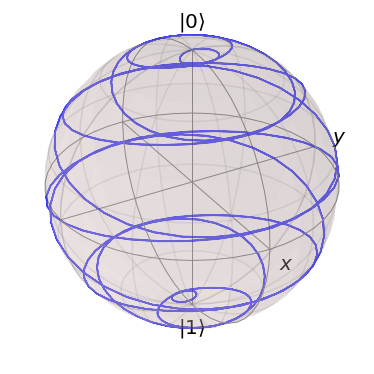

In [35]:
b = Bloch()
b.add_points([sx,sy,sz], meth = 'l')
b.view = [-120,30]
b.show()

The expectation for $ \sigma_z $ is:

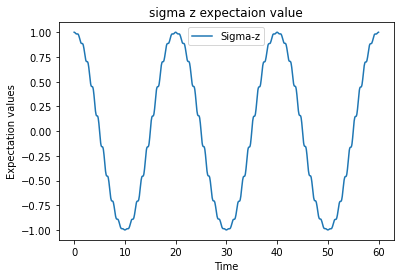

In [37]:
# expectaion plot
fig, ax = plt.subplots() 
ax.set_title("sigma z expectaion value")
ax.plot(expct_result.times, sz)
ax.set_xlabel('Time') 
ax.set_ylabel('Expectation values') 
ax.legend(("Sigma-z",)) 
plt.show() 

The probability of $ \sigma_z $ up and $\sigma_z$ down are: $ P(\sigma_z up) = \left (\langle z+ | \phi(t) \rangle \right)^2 $ 

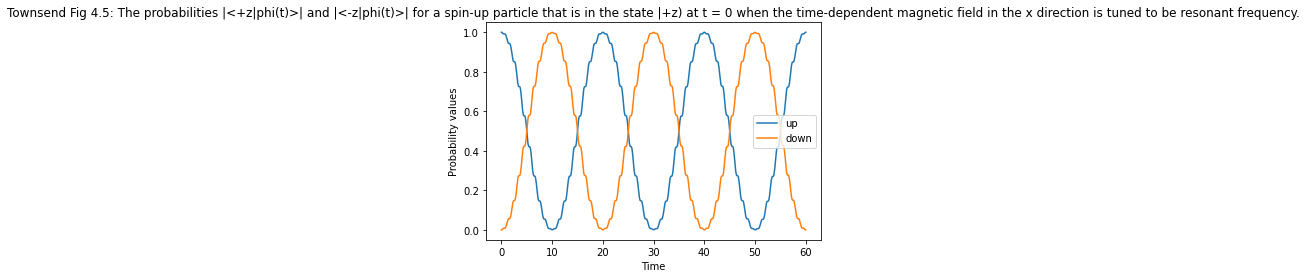

In [38]:
z_up_prob = []
z_down_prob = []
for state in states:
    prob = ((basis(2, 0).dag() * state).norm())**2
    z_up_prob.append(prob)
    z_down_prob.append(1 - prob)
fig1, ax1 = plt.subplots() 
ax1.set_title("Townsend Fig 4.5: The probabilities |<+z|phi(t)>| and |<-z|phi(t)>| for a spin-up particle that is in the state |+z) at t = 0 when the time-dependent magnetic field in the x direction is tuned to be resonant frequency.")
ax1.plot(times,  z_up_prob)
ax1.plot(times,  z_down_prob)
ax1.set_xlabel('Time') 
ax1.set_ylabel('Probability values') 
ax1.legend(("up", "down")) 
plt.show() 

To find the error in qutip simulation, we find the exact simulation:

In [39]:
z_down_prob_rabi = []
for t in times:
    z_down_prob_rabi.append((((w_1**2)/4)/((w_0-w)**2 + ((w_1**2)/4)))*(((np.sin(t*np.sqrt(((w_0 - w)**2)+((w_1**2)/4))/2))**2)))

Compare results:

Text(0.5, 1.0, 'Probability of Occupying Spin Down in the Z direction Over Time, from Townsend (Fig. 4.5)')

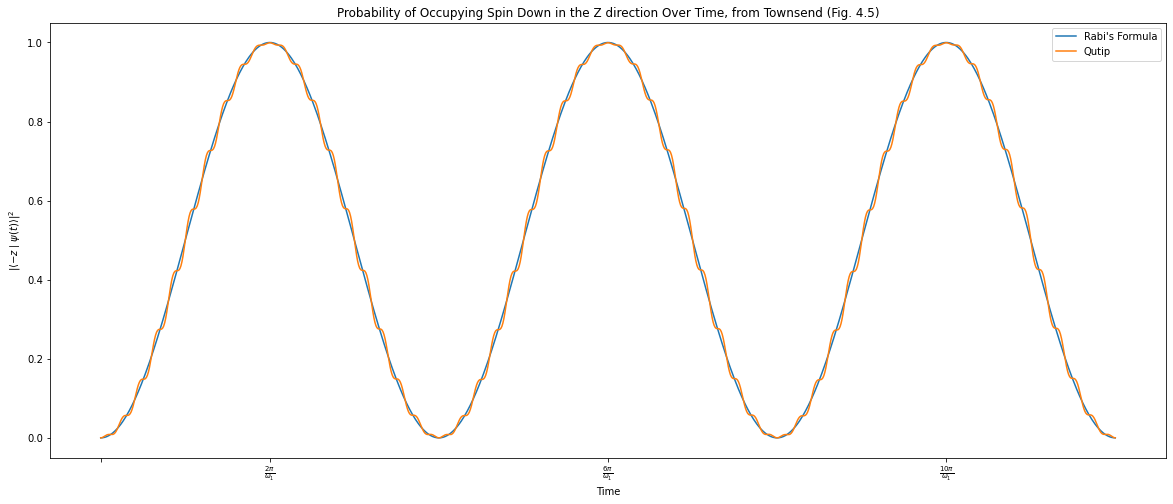

In [40]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(times, z_down_prob_rabi) 
p.plot(times, z_down_prob ) 
p.legend(("Rabi's Formula", "Qutip"))
p.set_xlabel('Time') 
p.set_xticks([0, 2*np.pi/w_1, 6*np.pi/w_1, 10*np.pi/w_1])
p.set_xticklabels(["", r"$\frac{2\pi}{\omega_1}$", r"$\frac{6\pi}{\omega_1}$", r"$\frac{10\pi}{\omega_1}$"])
p.set_ylabel(r"$|\langle{-z} \mid \psi(t)\rangle|^{2}$") 
p.set_title("Probability of Occupying Spin Down in the Z direction Over Time, from Townsend (Fig. 4.5)")

Find error (error is defined as the amplitude of the difference of the probabiliy of occupying spin down in the z direction):

Text(0.5, 1.0, 'Error in Probability of Occupying Spin Down in the Z direction Over Time, from Townsend (Fig. 4.5)')

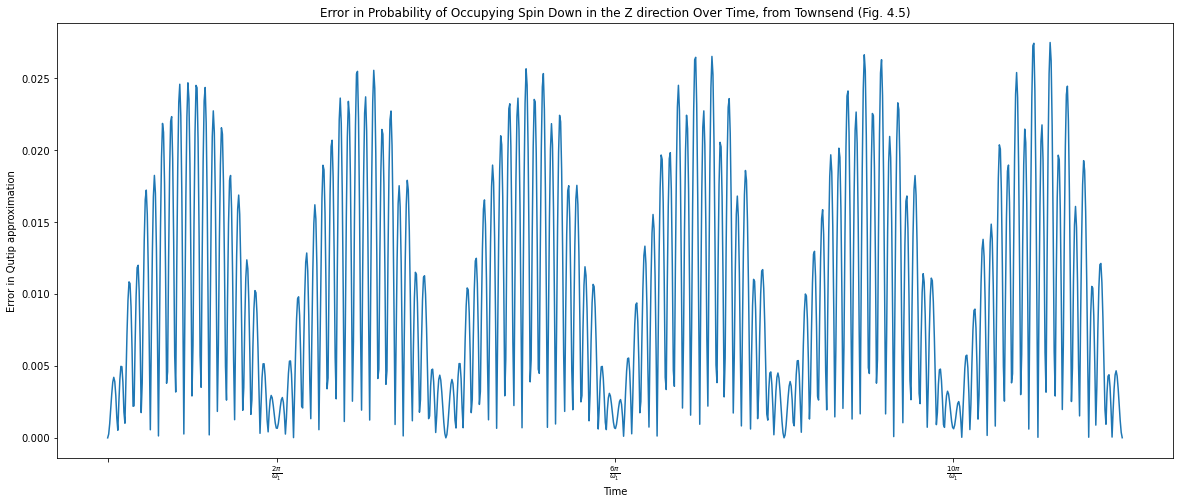

In [41]:
error = np.abs(np.asarray(z_down_prob_rabi) - np.asarray(z_down_prob))

p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(times, error)  
p.set_xlabel('Time') 
p.set_xticks([0, 2*np.pi/w_1, 6*np.pi/w_1, 10*np.pi/w_1])
p.set_xticklabels(["", r"$\frac{2\pi}{\omega_1}$", r"$\frac{6\pi}{\omega_1}$", r"$\frac{10\pi}{\omega_1}$"])
p.set_ylabel("Error in Qutip approximation") 
p.set_title("Error in Probability of Occupying Spin Down in the Z direction Over Time, from Townsend (Fig. 4.5)")